In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from utils.spikingjelly.spikingjelly.datasets.n_mnist import NMNIST
from utils.spikingjelly.spikingjelly.datasets import play_frame
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output
from typing import cast
from utils.types import Tensor2D
from utils.networks import STDPNet, DiehlAndCook2015
from utils.dataclasses import DistInfo
from typeguard import typechecked

In [2]:
## Deprecated code for mnist
# FILE_LIST = "MNIST/raw/train-images-idx3-ubyte MNIST/raw/train-labels-idx1-ubyte MNIST/raw/t10k-images-idx3-ubyte MNIST/raw/t10k-labels-idx1-ubyte".split()
# arrays:list[np.ndarray] = []

# for fname in FILE_LIST:
#     with open(fname,'rb') as f:
#         arrays.append(mnist.parse_idx(f))
# assert len(arrays) == 4
# train_imgs, train_labels, test_imgs, test_labels = arrays

In [3]:
w_min, w_max, w_mean, w_std = 0., 1., 0.5, 0.01
tau_pre, tau_post = 2., 2.
N_in, N_hidden, N_out = 2*34*34, 10, 10
T = 64
batch_size = 1
lr = 0.01

In [4]:
train_set = NMNIST("data/",train=True, data_type="frame", frames_number=T, split_by="number")
# test_set = NMNIST("data/",train=False, data_type="frame", frames_number=T, split_by="number")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

The directory [data/frames_number_64_split_by_number] already exists.


In [5]:
play_frame(train_set[15000][0], save_gif_to="data_sample.gif")

Save frames to [data_sample.gif].


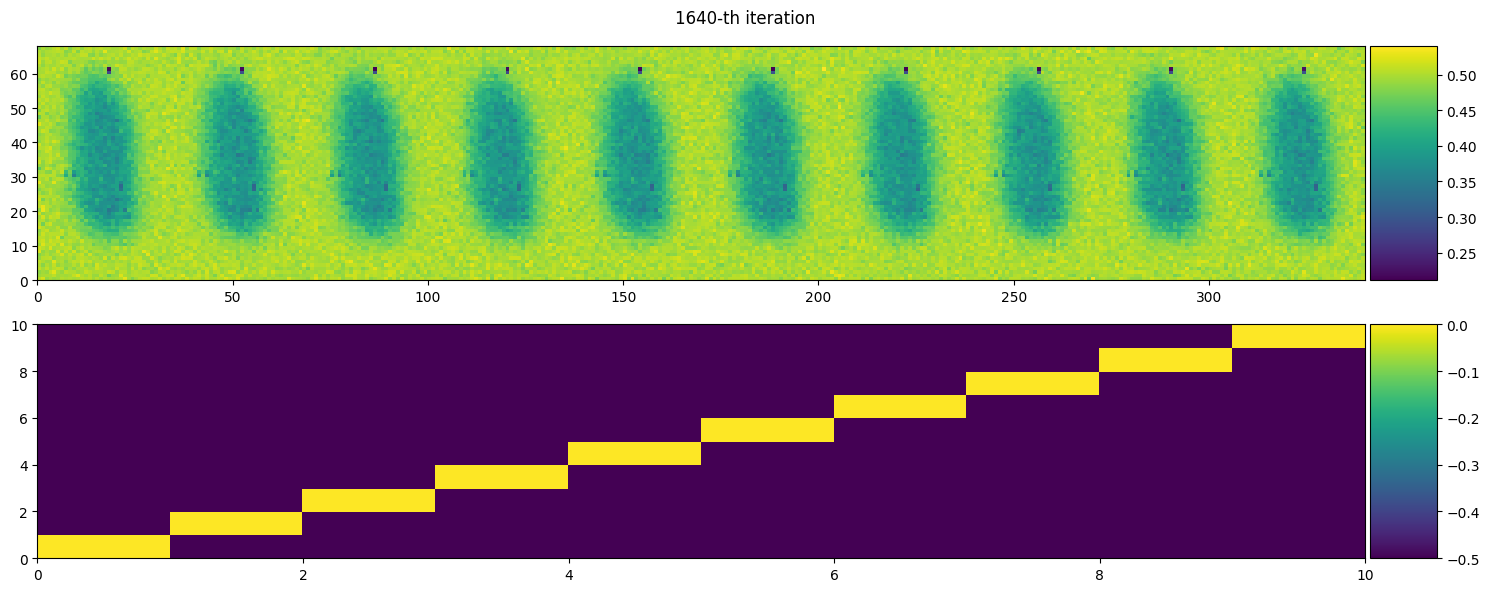

C:\Users\sizzf\AppData\Local\Temp\ipykernel_42864\2814508725.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame[:,::2,:] = torch.tensor(frames[:,t,0])
C:\Users\sizzf\AppData\Local\Temp\ipykernel_42864\2814508725.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame[:,1::2,:] = torch.tensor(frames[:,t,1])


In [6]:
device = ["cpu", "cuda"][torch.cuda.is_available()]

torch.manual_seed(0)

# plt.style.use(['science'])

w_info = DistInfo(w_min, w_max, w_mean, w_std)
net:STDPNet = cast(STDPNet, DiehlAndCook2015(2*34*34, N_hidden, tau_pre, tau_post, w_info).to(device))

optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

# Make figure to plot
fig = plt.figure(figsize=(15, 3*len(net.draw_ids)))
fig.suptitle(f"0-th iteration")

axes = []
caxes = []

# Subplot ops.
for i, draw_id in enumerate(net.draw_ids):
    axes.append(fig.add_subplot(len(net.draw_ids),1,i+1)) # generate new subplot.
    pc = axes[-1].pcolor(net.draw_weights(id=draw_id)) # make sub ax for color-number map.
    div = make_axes_locatable(axes[-1]) # get division of the subplot.
    caxes.append(div.append_axes("right", size="5%", pad=0.05)) # new ax for color bar
    fig.colorbar(pc, caxes[-1]) # make colorbar.
fig.tight_layout() # fit plots to layout
d_handle = display(fig, display_id=True) # jupyter display output
assert d_handle is not None # display handle must be valid.

with torch.no_grad():
    frame = torch.zeros((batch_size, 2*34, 34), requires_grad=False, device=device) # *2 for ON, OFF events
    loader = iter(train_loader)
    for i, (frames, label) in enumerate(loader, start=1):
        for t in range(T):
            assert frames.shape == (batch_size,64,2,34,34), f"{frames.shape}"
            optimizer.zero_grad()
            # out_spike.append(net(in_spike[t]))
            frame.fill_(0)
            frame[:,::2,:] = torch.tensor(frames[:,t,0])
            frame[:,1::2,:] = torch.tensor(frames[:,t,1])
            net(frame.reshape(batch_size,-1))
            
            for learner in net.learners:
                learner.step(on_grad=True)
            optimizer.step()
            net.post_optim()
            # weight.append(net[0].weight.data.clone())
            # trace_pre.append(learner.trace_pre)
            # trace_post.append(learner.trace_post)
        
        if i%10 == 0:
            fig.suptitle(f"{i}-th iteration")
            for i, draw_id in enumerate(net.draw_ids):
                pc = axes[i].pcolor(net.draw_weights(id=draw_id))
                fig.colorbar(pc, caxes[i])
            d_handle.update(fig)
        


In [ ]:
# out_spike = torch.stack(out_spike)   # [T, batch_size, N_out]
# trace_pre = torch.stack(trace_pre)   # [T, batch_size, N_in]
# trace_post = torch.stack(trace_post) # [T, batch_size, N_out]
# weight = torch.stack(weight)         # [T, N_out, N_in]

# # t = torch.arange(0, T).float()

# # in_spike = in_spike[:, 0, 0] # No in_spike generation
# out_spike = out_spike[:, 0, 0]
# trace_pre = trace_pre[:, 0, 0]
# trace_post = trace_post[:, 0, 0]
# weight = weight[:, 0, 0]

# cmap = plt.get_cmap('tab10')

# # No in_spike generation
# # plt.subplot(5, 1, 1)
# # plt.eventplot((in_spike * t)[in_spike == 1], lineoffsets=0, colors=cmap(0))
# # plt.xlim(-0.5, T + 0.5)
# # plt.ylabel('$s[i]$', rotation=0, labelpad=10)
# # plt.xticks([])
# # plt.yticks([])

# plt.subplot(5, 1, 2)
# plt.plot(t, trace_pre, c=cmap(1))
# plt.xlim(-0.5, T + 0.5)
# plt.ylabel('$tr_{pre}$', rotation=0)
# plt.yticks([trace_pre.min().item(), trace_pre.max().item()])
# plt.xticks([])

# plt.subplot(5, 1, 3)
# plt.eventplot((out_spike * t)[out_spike == 1], lineoffsets=0, colors=cmap(2))
# plt.xlim(-0.5, T + 0.5)
# plt.ylabel('$s[j]$', rotation=0, labelpad=10)
# plt.xticks([])
# plt.yticks([])

# plt.subplot(5, 1, 4)
# plt.plot(t, trace_post, c=cmap(3))
# plt.ylabel('$tr_{post}$', rotation=0)
# plt.yticks([trace_post.min().item(), trace_post.max().item()])
# plt.xlim(-0.5, T + 0.5)
# plt.xticks([])

# plt.subplot(5, 1, 5)
# plt.plot(t, weight, c=cmap(4))
# plt.xlim(-0.5, T + 0.5)
# plt.ylabel('$w[i][j]$', rotation=0)
# plt.yticks([weight.min().item(), weight.max().item()])
# plt.xlabel('time-step')

# plt.gcf().subplots_adjust(left=0.18)

# plt.show()
# plt.savefig('./stdp_trace.pdf')